# Notas de clase: Clasificación de un candidato a un empleo

- Objetivo: modelo para clasificar si un candidato es Apto/No Apto según sus habilidades.
- Dataset: sintético, con tres grupos de habilidades (técnicas, matemáticas, psicológicas) en distintos rangos.
- Etiqueta: se calcula a partir del promedio de los tres grupos (ver celda siguiente).
- Flujo general: generar datos → dividir y escalar → red → entrenar → evaluar → probar con un candidato nuevo.

### Dataset sintético: rangos por habilidad

In [1]:
import numpy as np
import pandas as pd

# Generar dataset sintético con diferentes rangos por habilidad
n_muestras = 5000
# Habilidades técnicas: 70-100
tec = np.random.randint(70, 101, (n_muestras, 6))
# Habilidades matemáticas: 60-90
mat = np.random.randint(60, 91, (n_muestras, 6))
# Habilidades psicológicas: 50-85
psi = np.random.randint(50, 86, (n_muestras, 6))
# Nombres de columnas
columnas = [
    'python', 'sql', 'visualizacion_datos', 'excel', 'manejo_apis', 'nube',
    'estadistica', 'probabilidad', 'algebra_lineal', 'calculo', 'optimizacion', 'modelado',
    'trabajo_equipo', 'comunicacion', 'creatividad', 'adaptabilidad', 'liderazgo', 'resolucion_problemas'
]
# Crear DataFrame
df = pd.DataFrame(np.concatenate([tec, mat, psi], axis=1), columns=columnas)

### Etiqueta
- Calculo promedios por grupo (tec, mat, psi) y luego el promedio total = media de esos tres.
- Regla de clase: `Apto = 1` si promedio total > 75; en otro caso `0`.
- Aplico one-hot para usar `categorical_crossentropy`.

In [2]:
# Calcular promedio por grupo y promedio total
prom_tecnologicas = df[['python', 'sql', 'visualizacion_datos', 'excel', 'manejo_apis', 'nube']].mean(axis=1)
prom_matematicas  = df[['estadistica', 'probabilidad', 'algebra_lineal', 'calculo', 'optimizacion', 'modelado']].mean(axis=1)
prom_psicologicas = df[['trabajo_equipo', 'comunicacion', 'creatividad', 'adaptabilidad', 'liderazgo', 'resolucion_problemas']].mean(axis=1)
# Promedio total = promedio de los 3 promedios
prom_total = (prom_tecnologicas + prom_matematicas + prom_psicologicas) / 3
# Etiqueta: 1 = Apto si promedio total > 75
y = (prom_total > 75).astype(int)
# one-hot encoding
y = pd.get_dummies(y).values

### División y escalado
- `train_test_split` con test_size=0.2 y random_state=42.
- Escalado estándar (`StandardScaler`): fit en train, transform en train y test.
- Importante: guardar el `scaler` para usarlo con datos nuevos.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42
)

# Escalamiento
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Red neuronal
- Modelo: MLP secuencial con capas densas [64, 32, 16] y activación ReLU.
- Capa de salida: 2 neuronas con `softmax` (porque hay dos clases y usamos one-hot).
- Optimizador: Adam lr=0.001; pérdida: `categorical_crossentropy`; métrica: `accuracy`.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
modelo = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

adam = Adam(learning_rate=0.001)
modelo.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

/home/nictez/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-03 20:27:34.382299: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Entrenamiento
- `epochs=50`, `batch_size=8`.
- Validación con el conjunto de test (pasado como `validation_data`).
- `verbose=1` para ver el progreso por época.

In [5]:
history = modelo.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8925 - loss: 0.2362 - val_accuracy: 0.9550 - val_loss: 0.1015
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9707 - loss: 0.0701 - val_accuracy: 0.9680 - val_loss: 0.0769
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9805 - loss: 0.0438 - val_accuracy: 0.9690 - val_loss: 0.0687
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9855 - loss: 0.0376 - val_accuracy: 0.9680 - val_loss: 0.0822
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9875 - loss: 0.0313 - val_accuracy: 0.9720 - val_loss: 0.0670
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9893 - loss: 0.0286 - val_accuracy: 0.9710 - val_loss: 0.0639
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9920 - loss: 0.0189 - val_accuracy: 0.9760 - val_loss: 0.0598
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9965 - loss: 0.0114 - val_accuracy: 0.

### Evaluación
- Grafico pérdidas de train y validación para detectar under/overfitting.
- Luego evalúo en test: imprimo `loss` y `accuracy` finales.

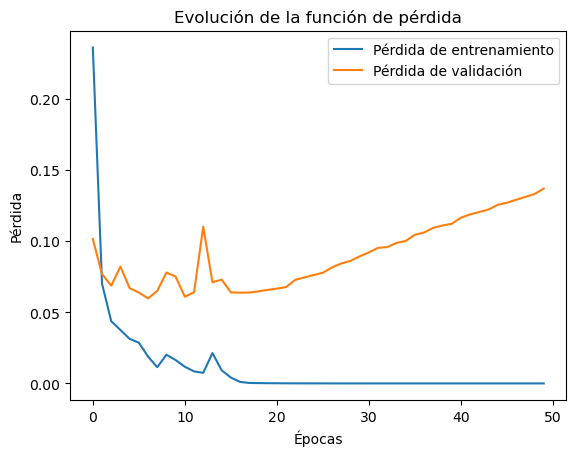

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9840 - loss: 0.1370      

🔹 Loss: 0.1370  |  Accuracy: 0.9840


In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la función de pérdida')
plt.show()

loss, acc = modelo.evaluate(X_test, y_test)
print(f"\n🔹 Loss: {loss:.4f}  |  Accuracy: {acc:.4f}")

### Matriz de confusión
- Con `confusion_matrix` veo aciertos/errores por clase.
- `ConfusionMatrixDisplay` para visualizar (colormap 'Blues').
- También calculo `recall` por clase: sensibilidad de detectar cada clase correctamente.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


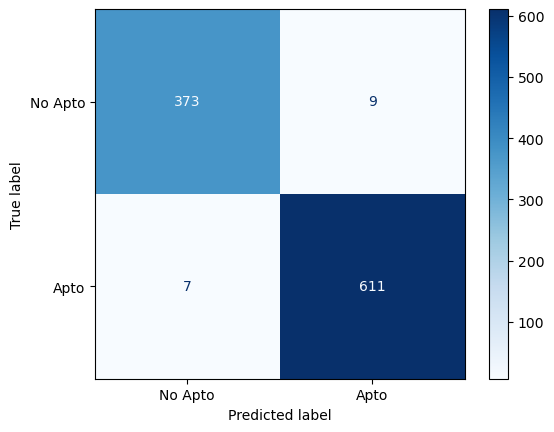


Sensitivity (Recall) por clase:
No Apto: 0.98
Apto: 0.99


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

pred = modelo.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Apto', 'Apto'])
disp.plot(cmap='Blues')
plt.show()

sensitivity = recall_score(y_true, y_pred, average=None)
print("\nSensitivity (Recall) por clase:")
print(f"No Apto: {sensitivity[0]:.2f}")
print(f"Apto: {sensitivity[1]:.2f}")

### Evaluar un nuevo candidato
- Recordatorio: siempre escalar con el `scaler` ajustado en train.
- `modelo.predict` devuelve probabilidades por clase (softmax); uso `argmax` para la clase final.
- Interpreto: 1 = Apto, 0 = No Apto.

In [8]:
nuevo_candidato = np.array([[90, 88, 85, 87, 84, 89,   # técnicas
                             82, 86, 85, 83, 87, 80,   # matemáticas
                             70, 75, 80, 72, 78, 74]]) # psicológicas

nuevo_candidato_scaled = scaler.transform(nuevo_candidato)
pred_nuevo = modelo.predict(nuevo_candidato_scaled)
clase_predicha = np.argmax(pred_nuevo)

print("Evaluación de nuevo candidato:")
print(f"Resultado: {'Apto' if clase_predicha == 1 else 'No Apto'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Evaluación de nuevo candidato:
Resultado: Apto


/home/nictez/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
